In [4]:
import rasterio
import numpy as np
from xml.dom import minidom

In [5]:
filename = "C:/Users/hfz_a/Downloads/IT-MBo_PSScene4Band_Explorer/files/PSScene4Band/20180626_093820_0f52/analytic/20180626_093820_0f52_3B_AnalyticMS.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

In [6]:
xmldoc = minidom.parse("C:/Users/hfz_a/Downloads/IT-MBo_PSScene4Band_Explorer/files/PSScene4Band/20180626_093820_0f52/analytic/20180626_093820_0f52_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [7]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [8]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.32203549517948854, 0.9998680928681444)

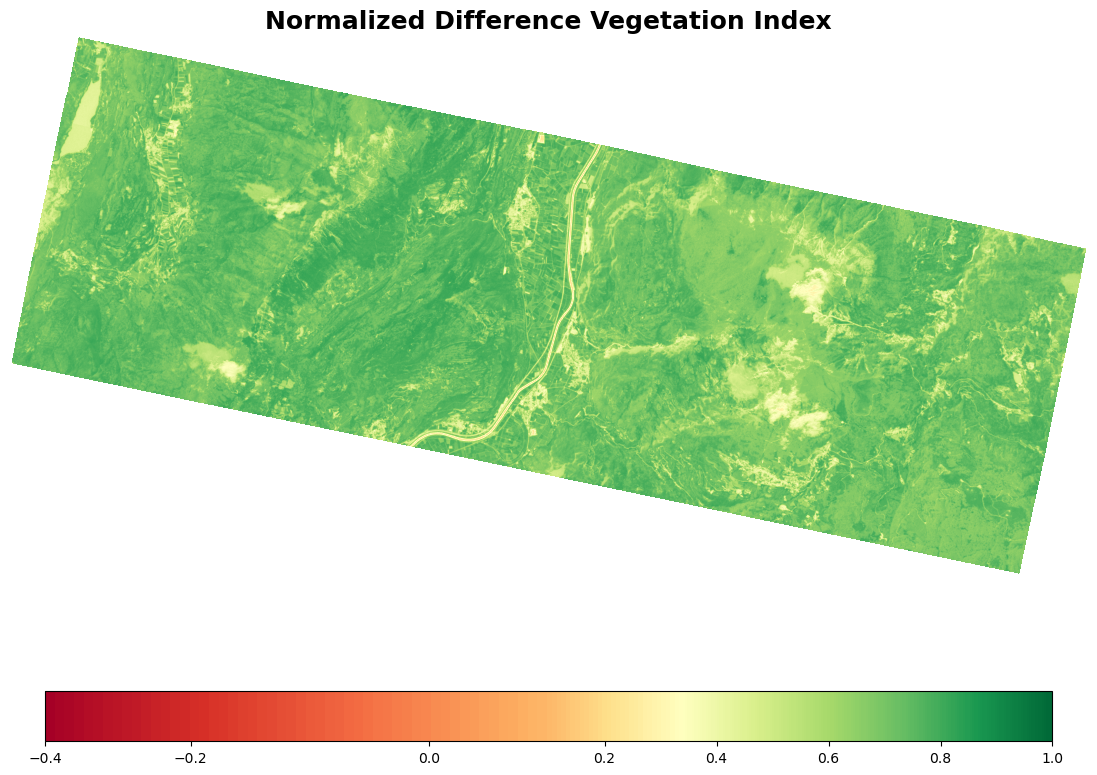

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

#fig.savefig("output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()


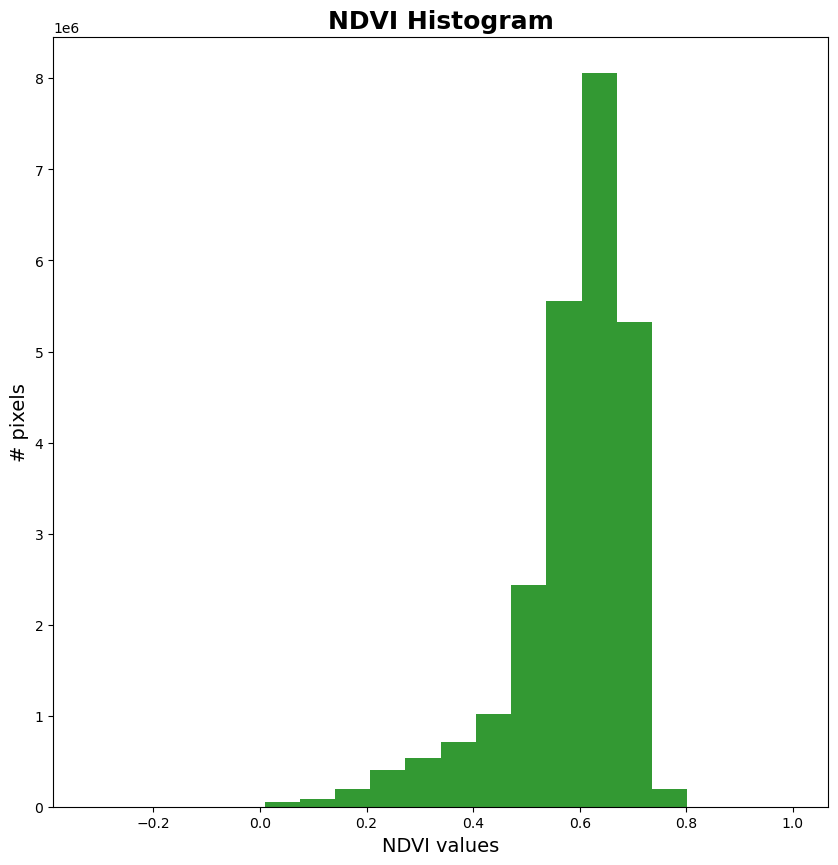

In [10]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

#fig2.savefig("output/ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [32]:
Map

Map(bottom=5962446.0, center=[46.09748948973548, 11.117348583785445], controls=(WidgetControl(options=['positi…

In [ ]:
#Maybe you feel like playing with the Map and see different colour/season combination efore generate the gif
vizParams = {'bands': ['summer', 'autumn', 'winter'], 'min': 0, 'max': 0.7, 'gamma': [0.95, 1.1, 1]}
Map.addLayer(show, vizParams, 'mycropsfirstviz')
#Notice that you also can use the Earh Engine amazing analysis capabilities
wintermax = myclass.get_year_composite().select('winter').max()
median = myclass.get_year_composite().median()
Map.addLayer(wintermax, {'min': 0, 'max': 0.75}, 'winterMax')
Map.addLayer(median, {'min': 0.1, 'max': 0.8}, 'median')

#To get the gif, ust use the method.
myclass.get_gif()

#Last, you can export your yearly seasonal NDVI composites to your computer
myclass.get_export()

